In [1]:
import tensorflow as tf
print(tf.keras.__version__)

3.8.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
test_ff = "/content/drive/MyDrive/FruitinAmazon/test"
train_ff = "/content/drive/MyDrive/FruitinAmazon/train"

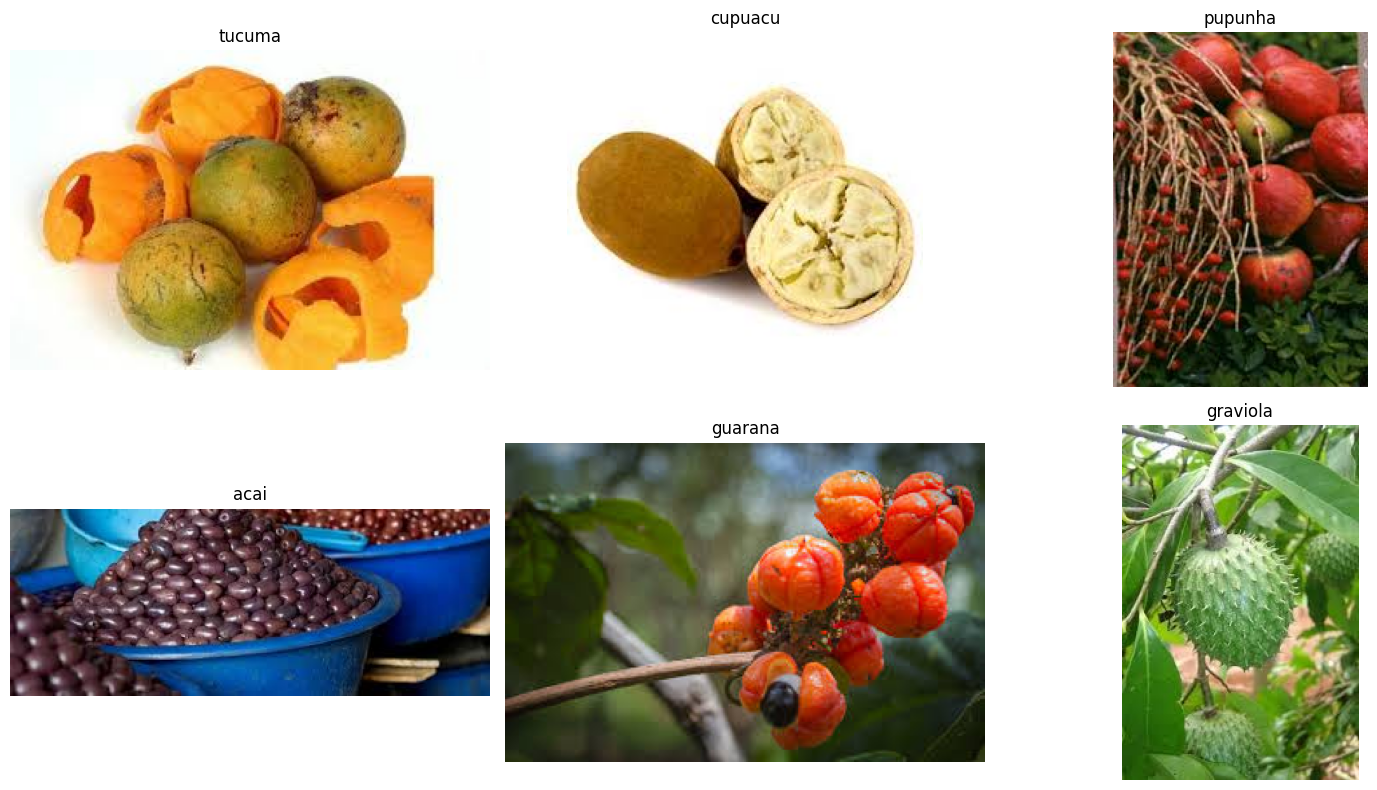

In [5]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def load_img(train_ff):


    selected_images = []
    class_labels = []
    for class_dir in [d for d in os.listdir(train_ff) if os.path.isdir(os.path.join(train_ff, d))]:
        class_path = os.path.join(train_ff, class_dir)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        if images:
            random_image = random.choice(images)
            selected_images.append(os.path.join(class_path, random_image))
            class_labels.append(class_dir)

    num_images = len(selected_images)
    cols = (num_images + 1) // 2

    fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(15, 8))
    axes = axes.flatten()

    for i, img_path in enumerate(selected_images):
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].set_title(class_labels[i])
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

load_img(train_ff)

Q) What did you obeserve?



= The code loads random imaegs from each class(folder) in the train_ff directory, dispalys them in a 2-row grid using matplotlib, and titles each images with its corresponding class name.

In [14]:
import logging
from PIL import Image

def remove_corrupted_images(train_ff):
    corrupted_images = []

    for class_dir in os.listdir(train_ff):
        class_path = os.path.join(train_ff, class_dir)
        if not os.path.isdir(class_path):
            continue

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")

    if not corrupted_images:
        print("No corrupted images found.")

remove_corrupted_images(train_ff)

No corrupted images found.


In [15]:
import tensorflow as tf

# Define image size and batch size
img_h, img_w = 128, 128
batch_size = 32
validation_split = 0.2

# Create a normalization layer
rescale = tf.keras.layers.Rescaling(1./255)

# Create training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_ff,
    labels='inferred',
    label_mode='int',
    image_size=(img_h, img_w),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Apply normalization
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_ff,
    labels='inferred',
    label_mode='int',
    image_size=(img_h, img_w),
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Apply normalization
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_h, img_w, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(os.listdir(train_ff)), activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=250, batch_size=16, callbacks=callbacks)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.1250 - loss: 2.4837

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 582ms/step - accuracy: 0.1250 - loss: 2.5632 - val_accuracy: 0.0000e+00 - val_loss: 1.6000
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.1892 - loss: 1.8175

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 781ms/step - accuracy: 0.1940 - loss: 1.8108 - val_accuracy: 0.8333 - val_loss: 1.5243
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 761ms/step - accuracy: 0.3524 - loss: 1.6785 - val_accuracy: 0.4444 - val_loss: 1.6039
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.2691 - loss: 1.5967

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 539ms/step - accuracy: 0.2747 - loss: 1.5902 - val_accuracy: 0.5556 - val_loss: 1.3543
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.3426 - loss: 1.4651

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 0.3576 - loss: 1.4568 - val_accuracy: 0.7222 - val_loss: 1.1580
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step - accuracy: 0.5078 - loss: 1.2422 - val_accuracy: 0.3333 - val_loss: 1.6185
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.7470 - loss: 1.0739 - val_accuracy: 0.5556 - val_loss: 1.1719
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8414 - loss: 0.8287

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 584ms/step - accuracy: 0.8325 - loss: 0.8313 - val_accuracy: 0.7778 - val_loss: 0.7861
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 744ms/step - accuracy: 0.8589 - loss: 0.6224 - val_accuracy: 0.8333 - val_loss: 0.9264
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9306 - loss: 0.4804

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - accuracy: 0.9271 - loss: 0.4817 - val_accuracy: 0.6111 - val_loss: 0.7639
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8848 - loss: 0.4276

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 483ms/step - accuracy: 0.8859 - loss: 0.4194 - val_accuracy: 0.8333 - val_loss: 0.6292
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - accuracy: 0.8958 - loss: 0.3279 - val_accuracy: 0.8333 - val_loss: 0.7735
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9502 - loss: 0.2076

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - accuracy: 0.9488 - loss: 0.2086 - val_accuracy: 0.8333 - val_loss: 0.4728
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 1.0000 - loss: 0.1393

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 615ms/step - accuracy: 1.0000 - loss: 0.1372 - val_accuracy: 0.8333 - val_loss: 0.4277
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step - accuracy: 0.9705 - loss: 0.1067 - val_accuracy: 0.8333 - val_loss: 0.4751
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 1.0000 - loss: 0.0696

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - accuracy: 1.0000 - loss: 0.0685 - val_accuracy: 0.8333 - val_loss: 0.3997
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step - accuracy: 1.0000 - loss: 0.0450 - val_accuracy: 0.8333 - val_loss: 0.4607
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 417ms/step - accuracy: 1.0000 - loss: 0.0280 - val_accuracy: 0.8333 - val_loss: 0.5127
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - accuracy: 1.0000 - loss: 0.0213 - val_accuracy: 0.8333 - val_loss: 0.4522
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 1.0000 - loss: 0.0143

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.8333 - val_loss: 0.3630
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 1.0000 - loss: 0.0070

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 807ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.8333 - val_loss: 0.3183
Epoch 22/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 604ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.8333 - val_loss: 0.3641
Epoch 23/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.8333 - val_loss: 0.4352
Epoch 24/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 502ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.8333 - val_loss: 0.5340
Epoch 25/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.8333 - val_loss: 0.5700
Epoch 26/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.8333 - val_loss: 0.5738


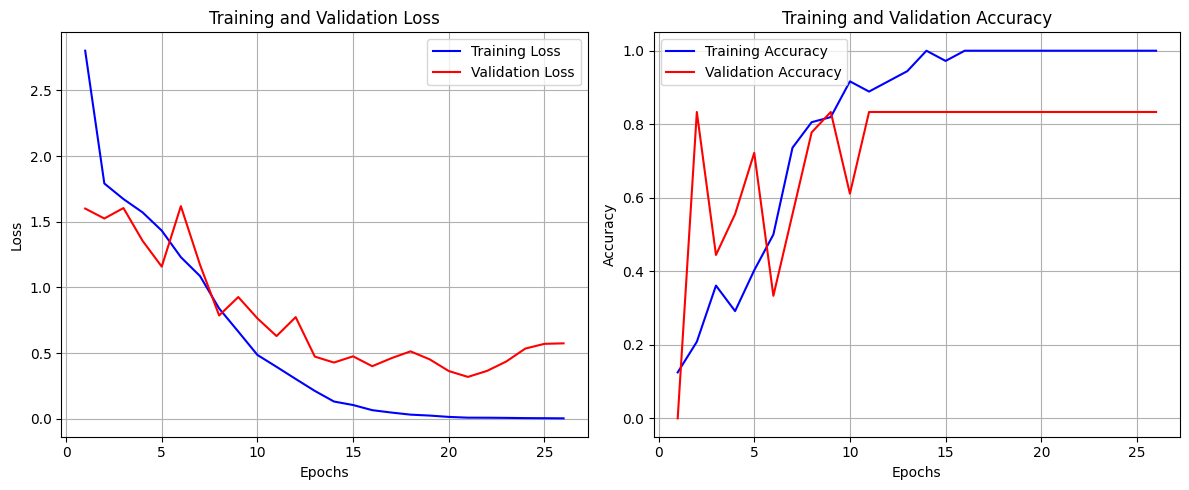

In [18]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [34]:
model.save('fruitsdetect.h5')
loaded_model = keras.models.load_model('fruitsdetect.h5')

print('model saved to fruitsdetect.h5')
print('model loaded from fruitsdetect.h5')

model saved to fruitsdetect.h5
model loaded from fruitsdetect.h5


In [32]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import classification_report

# Load the saved model
loaded_model = keras.models.load_model('fruitsdetect.h5')
print("Model loaded for predictions")

# Define image size
img_height, img_width = 128, 128
batch_size = 32

# **Create test dataset**
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_ff,  # Replace with the path to your test data directory
    labels='inferred',
    label_mode='categorical',  # Use categorical for classification_report
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # Important for consistent evaluation
)

# Collect all test images and labels
all_images = []
all_labels = []
for images, labels in test_dataset:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Concatenate batches into single arrays
test_images = np.concatenate(all_images, axis=0)
test_labels_onehot = np.concatenate(all_labels, axis=0)

# Make predictions
predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)

# Get class names from the dataset
class_names = test_dataset.class_names # Access class names from test_dataset
print(f"Class names: {class_names}")

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

Model loaded for predictions
Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Classification Report:
               precision    recall  f1-score   support

        acai       0.80      0.80      0.80         5
     cupuacu       0.50      0.60      0.55         5
    graviola       0.71      1.00      0.83         5
     guarana       0.67      0.80      0.73         5
     pupunha       1.00      0.60      0.75         5
      tucuma       0.67      0.40      0.50         5

    accuracy                           0.70        30
   macro avg       0.72      0.70      0.69        30
weighted avg       0.72      0.70      0.69        30

